Isentropic Analysis
===================

The MetPy function `metpy.calc.isentropic_interpolation` allows for isentropic analysis from
model analysis data in isobaric coordinates.

In [1]:
from datetime import datetime, timedelta

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import metpy.calc
from metpy.units import units
from netCDF4 import num2date
import numpy as np
from siphon.catalog import TDSCatalog

Getting the data

In this example, the latest GFS forecasts data from the National Centers for
Environmental Information (https://nomads.ncdc.noaa.gov) will be used, courtesy of the
Univeristy Corporation for Atmospheric Research Thredds Data Server.

In [2]:
# Latest GFS Dataset
cat = TDSCatalog('http://thredds.ucar.edu/thredds/catalog/grib/'
                 'NCEP/GFS/Global_0p5deg/catalog.xml')
ncss = cat.latest.subset()

# Find the start of the model run and define time range
start_time = ncss.metadata.time_span['begin']
start = datetime.strptime(start_time, '%Y-%m-%dT%H:%M:%Sz')
end = start + timedelta(hours=9)

# Query for Latest GFS Run
gfsdata = ncss.query().time_range(start, end).accept('netcdf4')

gfsdata.variables('Temperature_isobaric',
                  'u-component_of_wind_isobaric',
                  'v-component_of_wind_isobaric',
                  'Relative_humidity_isobaric').add_lonlat()

# Set the lat/lon box for the data you want to pull in.
# lonlat_box(north_lat,south_lat,east_lon,west_lon)
gfsdata.lonlat_box(-150, -50, 15, 65)

# Actually getting the data
data = ncss.get_data(gfsdata)

dtime = data.variables['Temperature_isobaric'].dimensions[0]
dlev_hght = data.variables['Temperature_isobaric'].dimensions[1]
dlev_uwnd = data.variables['u-component_of_wind_isobaric'].dimensions[1]
lat = data.variables['lat'][:]
lon = data.variables['lon'][:]

lev_var = data.variables[dlev_hght]
lev_hght = units.Quantity(lev_var[:], lev_var.units)

lev_var = data.variables[dlev_uwnd]
lev_uwnd = units.Quantity(lev_var[:], lev_var.units)
# Due to a different number of vertical levels find where they are common
_, _, common_ind = np.intersect1d(lev_uwnd.magnitude, lev_hght.magnitude, return_indices=True)
times = data.variables[dtime]
vtimes = num2date(times[:], times.units)
temps = data.variables['Temperature_isobaric']
tmp = units.Quantity(temps[:, common_ind, :, :], temps.units)
uwnd_var = data.variables['u-component_of_wind_isobaric']
uwnd = units.Quantity(uwnd_var[:], uwnd_var.units)
vwnd_var = data.variables['v-component_of_wind_isobaric']
vwnd = units.Quantity(vwnd_var[:], vwnd_var.units)
relh = data.variables['Relative_humidity_isobaric'][:]

To properly interpolate to isentropic coordinates, the function must know the desired output
isentropic levels. An array with these levels will be created below.

In [3]:
isentlevs = np.arange(310, 316, 5) * units.kelvin

Conversion to Isentropic Coordinates

Once model data in isobaric coordinates has been pulled and the desired isentropic levels
created, the conversion to isentropic coordinates can begin. Data will be passed to the
function as below. The function requires that isentropic levels, isobaric levels, and
temperature be input. Any additional inputs (in this case relative humidity, u, and v wind
components) will be linearly interpolated to isentropic space.

In [4]:
isent_anal = metpy.calc.isentropic_interpolation(isentlevs, lev_uwnd, tmp,
                                                 relh, uwnd, vwnd, axis=1)

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/metpy/interpolate/one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


The output is a list, so now we will separate the variables to different names before
plotting.

In [5]:
isentprs, isentrh, isentu, isentv = isent_anal

A quick look at the shape of these variables will show that the data is now in isentropic
coordinates, with the number of vertical levels as specified above.

In [6]:
print(isentprs.shape)
print(isentrh.shape)
print(isentu.shape)
print(isentv.shape)

(4, 2, 101, 201)
(4, 2, 101, 201)
(4, 2, 101, 201)
(4, 2, 101, 201)


**Plotting the Isentropic Analysis**

Set up our projection

/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/numpy/ma/core.py:3225: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  dout = self.data[indx]
/home/travis/miniconda/envs/unidata/lib/python3.7/site-packages/numpy/ma/core.py:3257: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an er

Text(1.0, 1.0, 'VALID: 2020-08-28 06:00:00 UTC')

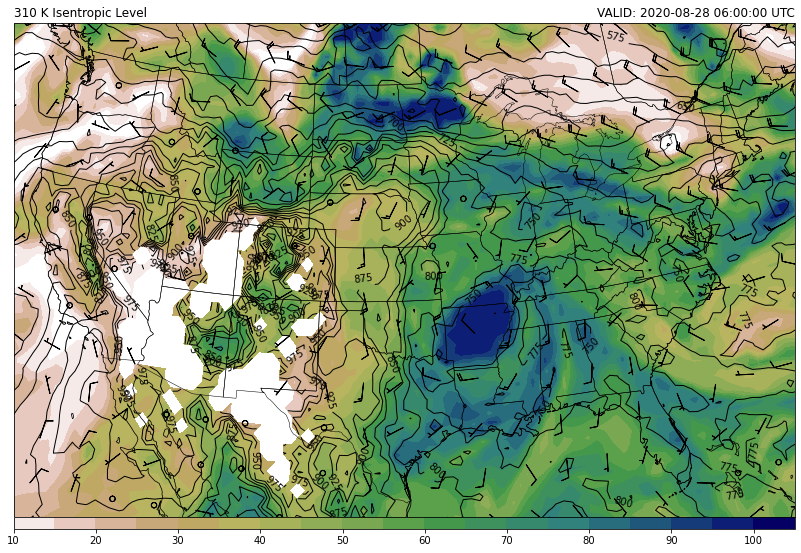

In [7]:
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Set up our array of latitude and longitude values and transform to
# the desired projection.
clons, clats = np.meshgrid(lon, lat)

# Get data to plot state and province boundaries
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lakes',
    scale='50m',
    facecolor='none')
level = 0
FH = 0
fig = plt.figure(1, figsize=(14., 12.))
ax = plt.subplot(111, projection=crs)

# Set plot extent
ax.set_extent((-121., -74., 25., 50.), crs=ccrs.PlateCarree())
ax.coastlines('50m', edgecolor='black', linewidth=0.75)
ax.add_feature(states_provinces, edgecolor='black', linewidth=0.5)

# Plot the 300K surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(clons, clats, isentprs[FH, level, :, :], clevisent,
                transform=ccrs.PlateCarree(),
                colors='k', linewidths=1.0, linestyles='solid')
plt.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
           fmt='%i', rightside_up=True, use_clabeltext=True)

cf = ax.contourf(clons, clats, isentrh[FH, level, :, :], range(10, 106, 5),
                 transform=ccrs.PlateCarree(),
                 cmap=plt.cm.gist_earth_r)
plt.colorbar(cf, orientation='horizontal', extend=max, aspect=65, pad=0,
             extendrect='True')

wind_slice = [FH, level, slice(None, None, 5), slice(None, None, 5)]
ax.barbs(clons[wind_slice[2:]], clats[wind_slice[2:]],
         isentu[wind_slice].m, isentv[wind_slice].m, length=6,
         transform=ccrs.PlateCarree())

# Make some titles
plt.title('{:.0f} K Isentropic Level'.format(isentlevs[level].m), loc='left')
plt.title('VALID: {:s} UTC'.format(str(vtimes[FH])), loc='right')